In [ ]:
pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 62.6 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassAccuracy
import os
import time
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
from tqdm import tqdm

print(os.cpu_count())

12


In [ ]:
transform = T.Compose([
    T.Resize((40, 200)),
    T.ToTensor()
])

def load_and_transform(path, transform=transform):
    img = Image.open(path).convert("RGB")
    img.load()  # force decode
    if transform:
        img = transform(img)
    return img

In [ ]:
def load_images_with_progress(filenames, transform=None):
    num_cores = multiprocessing.cpu_count()
    images = []

    with ProcessPoolExecutor(max_workers=10) as executor:
        images = list(tqdm(executor.map(load_and_transform, filenames), total=len(filenames), desc="Loading images"))

    return images

In [ ]:
class OCRDataset(Dataset):
    def __init__(self, csv_files, train, frac=0.9, text_label=False, transform=None):
        dfs = [pd.read_csv(f) for f in csv_files]
        self.data = pd.concat(dfs, ignore_index=True)
        self.transform = transform
        self.text_label = text_label
        self.train = train

        train_data = self.data.sample(frac=frac, random_state=42)
        test_data = self.data.drop(train_data.index)

        if train:
            self.data = train_data
        else:
            self.data = test_data

        self.filenames = list(self.data["filename"])
        self.images = load_images_with_progress(self.filenames, self.transform)
        self.labels = list(self.data['number'])

        self.label_names = list(self.data['label'])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.text_label:
            return self.images[idx], self.label_names[idx], self.labels[idx]
        else:
            return self.images[idx], self.labels[idx]

In [ ]:
path_easy = r'/content/drive/MyDrive/Captcha/labels_easy.csv'
path_0 = r'/content/drive/MyDrive/Captcha/labels_Hard_0.csv'
path_1 = r'/content/drive/MyDrive/Captcha/labels_Hard_1.csv'

paths = [path_easy, path_0, path_1]

train_transform = T.Compose([
    T.Resize((40, 200)),
    T.RandomRotation(15),
    T.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9,1.1)),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

train_set = OCRDataset(csv_files=paths, train=True)
test_set = OCRDataset(csv_files=paths, train=False)

Loading images: 100%|██████████| 5100/5100 [03:58<00:00, 21.42it/s]


In [ ]:
len(train_set), len(test_set)

(45900, 5100)

In [ ]:
B = 256

train_loader = DataLoader(train_set, batch_size=B, shuffle=True)
test_loader = DataLoader(test_set, batch_size=B, shuffle=False)

len(train_loader), len(test_loader)

(180, 20)

In [ ]:
torch.manual_seed(4)
model = models.resnet18(weights=None)

num_classes = 100


model.fc = nn.Sequential(
    nn.Dropout(0.5, inplace=True),
    nn.Linear(model.fc.in_features, 100)
)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:,}\n")

Number of parameters: 11,227,812



In [ ]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.Dropout(0.1, inplace=True),
                            nn.ReLU(inplace=True))
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

In [ ]:
class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 100):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 4, stride = 1, padding = 1),
                            nn.BatchNorm2d(64),
                            nn.ReLU(inplace=True))
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d((3, 13), stride=1)

            self.fc = nn.Sequential(nn.Linear(512, num_classes),
                                    nn.Dropout(0.5, inplace=True))

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

In [ ]:
class MNIST_CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7168,
                      out_features=output_shape)
        )
    def forward(self, x):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.conv_block_3(x)
        x=self.conv_block_4(x)

        x=self.classifier(x)
        return x

In [ ]:
#model = ResNet(ResidualBlock, [1, 1, 1, 1])

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:,}\n")

Number of parameters: 11,227,812



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
metric = MulticlassAccuracy(num_classes=100).to(device)

In [ ]:
num_epochs = 30

epoch_train_losses = []
epoch_test_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []

for epoch in range(num_epochs):
    model.train()

    train_losses = []
    train_accuracies = []

    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)           # [B, num_classes]
        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        accuracy = metric(outputs, labels) * 100

        train_losses.append(loss.item())
        train_accuracies.append(accuracy)


    model.eval()

    test_losses = []
    test_accuracies = []

    for images, labels in tqdm(test_loader, desc='Testing '):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)           # [B, num_classes]
        loss = criterion(outputs, labels)

        accuracy = metric(outputs, labels) * 100

        test_accuracies.append(accuracy)
        test_losses.append(loss)

    train_loss = torch.mean(torch.tensor(train_losses))
    test_loss = torch.mean(torch.tensor(test_losses))

    train_accuracy = torch.mean(torch.tensor(train_accuracies))
    test_accuracy = torch.mean(torch.tensor(test_accuracies))


    epoch_train_losses.append(train_loss)
    epoch_test_losses.append(test_loss)
    epoch_train_accuracies.append(train_accuracy)
    epoch_test_accuracies.append(test_accuracy)

    print()
    print(f"Epoch [{epoch+1}/{num_epochs}]  |   Train Loss: {train_loss:.4f}    |   Train Accuracy = {train_accuracy:.2f} %   |   Test Loss = {test_loss:.4f}   |   Test Accuracy = {test_accuracy:.2f} %  ")
    print()

Testing : 100%|██████████| 20/20 [00:00<00:00, 38.72it/s]



Epoch [1/30]  |   Train Loss: 3.5469    |   Train Accuracy = 7.12 %   |   Test Loss = 4.1013   |   Test Accuracy = 6.72 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 38.86it/s]



Epoch [2/30]  |   Train Loss: 1.9527    |   Train Accuracy = 39.33 %   |   Test Loss = 1.2058   |   Test Accuracy = 62.01 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 38.97it/s]



Epoch [3/30]  |   Train Loss: 0.5674    |   Train Accuracy = 81.57 %   |   Test Loss = 0.4795   |   Test Accuracy = 83.49 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.07it/s]



Epoch [4/30]  |   Train Loss: 0.2345    |   Train Accuracy = 92.19 %   |   Test Loss = 0.2467   |   Test Accuracy = 91.18 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.74it/s]



Epoch [5/30]  |   Train Loss: 0.1361    |   Train Accuracy = 95.24 %   |   Test Loss = 0.1899   |   Test Accuracy = 92.80 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.53it/s]



Epoch [6/30]  |   Train Loss: 0.0994    |   Train Accuracy = 96.66 %   |   Test Loss = 0.2070   |   Test Accuracy = 93.01 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.49it/s]



Epoch [7/30]  |   Train Loss: 0.0704    |   Train Accuracy = 97.60 %   |   Test Loss = 0.1427   |   Test Accuracy = 95.30 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.42it/s]



Epoch [8/30]  |   Train Loss: 0.0453    |   Train Accuracy = 98.45 %   |   Test Loss = 0.2850   |   Test Accuracy = 90.77 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.33it/s]



Epoch [9/30]  |   Train Loss: 0.0520    |   Train Accuracy = 98.21 %   |   Test Loss = 0.1643   |   Test Accuracy = 94.98 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.14it/s]



Epoch [10/30]  |   Train Loss: 0.0298    |   Train Accuracy = 98.94 %   |   Test Loss = 0.1677   |   Test Accuracy = 94.46 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 38.96it/s]



Epoch [11/30]  |   Train Loss: 0.0395    |   Train Accuracy = 98.59 %   |   Test Loss = 0.1444   |   Test Accuracy = 95.69 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.40it/s]



Epoch [12/30]  |   Train Loss: 0.0352    |   Train Accuracy = 98.73 %   |   Test Loss = 0.0994   |   Test Accuracy = 96.48 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 38.39it/s]



Epoch [13/30]  |   Train Loss: 0.0265    |   Train Accuracy = 99.11 %   |   Test Loss = 0.0818   |   Test Accuracy = 97.63 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.15it/s]



Epoch [14/30]  |   Train Loss: 0.0176    |   Train Accuracy = 99.44 %   |   Test Loss = 0.1445   |   Test Accuracy = 95.99 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.23it/s]



Epoch [15/30]  |   Train Loss: 0.0316    |   Train Accuracy = 98.81 %   |   Test Loss = 0.1680   |   Test Accuracy = 94.92 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.29it/s]



Epoch [16/30]  |   Train Loss: 0.0182    |   Train Accuracy = 99.39 %   |   Test Loss = 0.1124   |   Test Accuracy = 96.55 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.41it/s]



Epoch [17/30]  |   Train Loss: 0.0306    |   Train Accuracy = 98.99 %   |   Test Loss = 0.1343   |   Test Accuracy = 95.85 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.09it/s]



Epoch [18/30]  |   Train Loss: 0.0296    |   Train Accuracy = 98.95 %   |   Test Loss = 0.1887   |   Test Accuracy = 93.84 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.02it/s]



Epoch [19/30]  |   Train Loss: 0.0312    |   Train Accuracy = 98.80 %   |   Test Loss = 0.0820   |   Test Accuracy = 97.55 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.44it/s]



Epoch [20/30]  |   Train Loss: 0.0149    |   Train Accuracy = 99.53 %   |   Test Loss = 0.0867   |   Test Accuracy = 97.41 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.06it/s]



Epoch [21/30]  |   Train Loss: 0.0201    |   Train Accuracy = 99.31 %   |   Test Loss = 0.0873   |   Test Accuracy = 97.34 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.07it/s]



Epoch [22/30]  |   Train Loss: 0.0235    |   Train Accuracy = 99.17 %   |   Test Loss = 0.0932   |   Test Accuracy = 97.11 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 38.83it/s]



Epoch [23/30]  |   Train Loss: 0.0280    |   Train Accuracy = 98.99 %   |   Test Loss = 0.0890   |   Test Accuracy = 97.21 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.47it/s]



Epoch [24/30]  |   Train Loss: 0.0226    |   Train Accuracy = 99.18 %   |   Test Loss = 0.0755   |   Test Accuracy = 97.60 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.34it/s]



Epoch [25/30]  |   Train Loss: 0.0108    |   Train Accuracy = 99.61 %   |   Test Loss = 0.0746   |   Test Accuracy = 97.55 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.51it/s]



Epoch [26/30]  |   Train Loss: 0.0082    |   Train Accuracy = 99.68 %   |   Test Loss = 0.1305   |   Test Accuracy = 96.02 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.62it/s]



Epoch [27/30]  |   Train Loss: 0.0160    |   Train Accuracy = 99.51 %   |   Test Loss = 0.0966   |   Test Accuracy = 97.61 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.41it/s]



Epoch [28/30]  |   Train Loss: 0.0133    |   Train Accuracy = 99.55 %   |   Test Loss = 0.1541   |   Test Accuracy = 95.32 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 38.85it/s]



Epoch [29/30]  |   Train Loss: 0.0250    |   Train Accuracy = 99.11 %   |   Test Loss = 0.1017   |   Test Accuracy = 96.78 %  



Testing : 100%|██████████| 20/20 [00:00<00:00, 39.01it/s]


Epoch [30/30]  |   Train Loss: 0.0187    |   Train Accuracy = 99.36 %   |   Test Loss = 0.0771   |   Test Accuracy = 97.42 %  



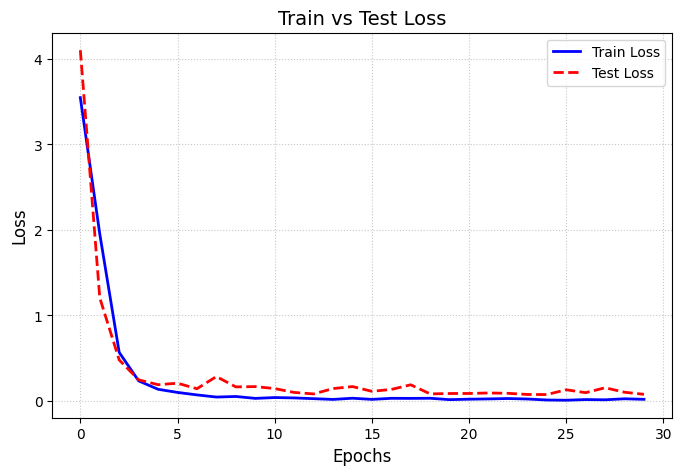

In [ ]:
plt.figure(figsize=(8, 5))


plt.plot(epoch_train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(epoch_test_losses, label='Test Loss', color='red', linestyle='--', linewidth=2)


plt.title('Train vs Test Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)


plt.grid(True, linestyle=':', alpha=0.7)


plt.legend()


plt.show()

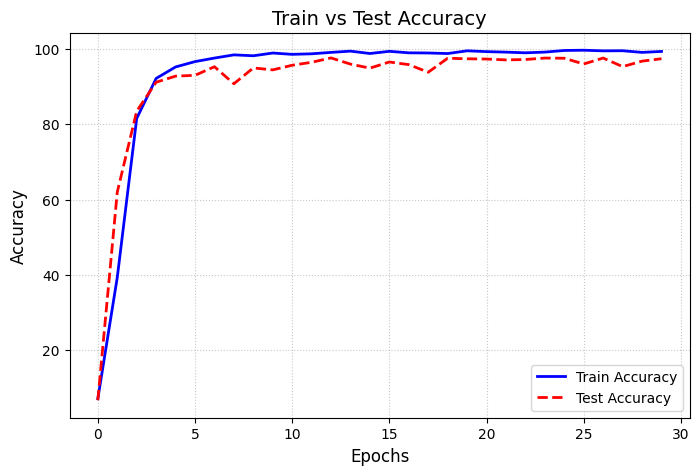

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(epoch_train_accuracies, label='Train Accuracy', color='blue', linewidth=2)
plt.plot(epoch_test_accuracies, label='Test Accuracy', color='red', linestyle='--', linewidth=2)

plt.title('Train vs Test Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.grid(True, linestyle=':', alpha=0.7)

plt.legend()

plt.show()